# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [ ]:
name = 'Andrey Popov'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [1]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [12]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse
import unittest
from unittest.mock import patch

def get_all_links(url: str):
    """
    Get all the links in the webpage at the given URL

    :param url: A string that is the URL of the webpage where we need to find the links
    :return: A list with all the links of the given webpage
    """

    if not isinstance(url, str):
        raise ValueError("URL must be a string.")

    parsed_url = urlparse(url)
    if not parsed_url.scheme or not parsed_url.netloc:
        raise ValueError("Invalid URL provided.")

    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        raise ConnectionError(f"Failed to fetch the URL: {e}")

    soup = BeautifulSoup(response.text, 'html.parser')
    links = set()
    for a_tag in soup.find_all('a', href=True):
        href = a_tag['href']
        # Convert relative URLs to absolute URLs
        full_url = urljoin(url, href)
        # Optionally, filter out mailto and javascript links
        if full_url.startswith(('http://', 'https://')):
            links.add(full_url)

    return list(links)

In [4]:
get_all_links('http://en.wikipedia.com')[:10]

['http://en.wikipedia.com/wiki/Special:SpecialPages',
 'http://en.wikipedia.com/wiki/Special:RecentChangesLinked/Main_Page',
 'http://en.wikipedia.com/wiki/Help:Introduction_to_Wikipedia',
 'http://en.wikipedia.com/wiki/Timeline_of_the_Russian_invasion_of_Ukraine_(1_January_2025_%E2%80%93_present)',
 'https://sv.wikipedia.org/wiki/',
 'https://ru.wikipedia.org/wiki/',
 'http://en.wikipedia.com/wiki/1419',
 'http://en.wikipedia.com/wiki/Northern_California',
 'http://en.wikipedia.com/wiki/Special:MyTalk',
 'http://en.wikipedia.com/wiki/Orange_Walk_District']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [6]:
def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the html content of each of them

    :param url: A string that is the URL of the webpage
    """
    links = get_all_links(url)
    for link in links:
        try:
            response = requests.get(link)
            response.raise_for_status()
            yield response.text
        except requests.RequestException:
            # Optionally, you can log the error or skip silently
            continue

# Testing function usage
#for page_content in get_neighbor_pages('http://en.wikipedia.org'):
    p#rint(page_content[:500])

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-disabled skin-theme-clientpref-day ve
<!DOCTYPE html>
<html class="client-nojs" lang="ru" dir="ltr">
<head>
<meta charset="UTF-8">
<title>Википедия — свободная энциклопедия</title>
<script>(function(){var className="client-js";var cookie=document.cookie.match(/(?:^|; )ruwikimwclientpreferences=([^;]+)/);if(cookie){cookie[1].split('%2C').forEach(function(pref){className=className.replace(new RegExp('(^| )'+pref.replace(/-clientpref-\w+$|[^\w-]+/g,'')+'-clientpref-\\w+( |$)'),'$1'+pref+'$2');});}document.documentElement.className=cla

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

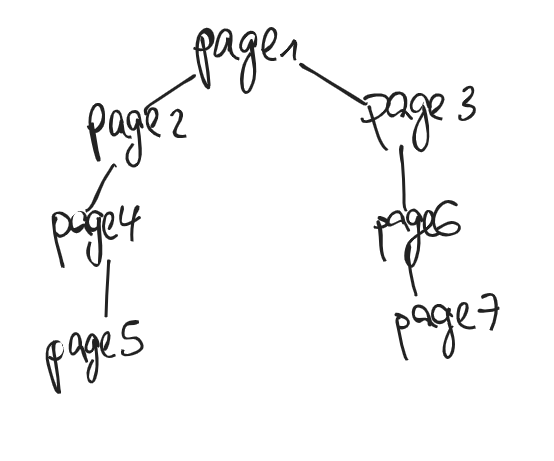

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [22]:
from collections import deque
from functools import wraps
from typing import Set, Generator
from urllib.parse import urlparse, urljoin

def get_pages_depth(url: str, depth: int) -> Generator[str, None, None]:
    """
    Traverse web pages starting from the given URL up to the specified depth
    and yield the HTML content of each unique page encountered.

    :param url: A string representing the starting URL.
    :param depth: An integer indicating how deep the traversal should go.
    :return: A generator yielding HTML content of each page.
    """
    if not isinstance(url, str):
        raise ValueError("URL must be a string.")
    if not isinstance(depth, int) or depth < 0:
        raise ValueError("Depth must be a non-negative integer.")

    visited: Set[str] = set()
    queue = deque()
    queue.append((url, 0))
    visited.add(url)

    while queue:
        current_url, current_depth = queue.popleft()
        try:
            response = requests.get(current_url, timeout=5)
            response.raise_for_status()
            html_content = response.text
            yield html_content
        except requests.RequestException as e:
            print(f"Failed to fetch {current_url}: {e}")
            continue

        if current_depth < depth:
            try:
                soup = BeautifulSoup(html_content, 'html.parser')
                for a_tag in soup.find_all('a', href=True):
                    href = a_tag['href']
                    # Convert relative URLs to absolute URLs
                    full_url = urljoin(current_url, href)
                    # Parse the URL to ensure it's valid and within the same domain
                    parsed_full_url = urlparse(full_url)
                    parsed_start_url = urlparse(url)
                    # Optionally, restrict to the same domain to prevent crawling external sites
                    if parsed_full_url.netloc != parsed_start_url.netloc:
                        continue
                    # Filter out non-http(s) URLs
                    if full_url.startswith(('http://', 'https://')):
                        if full_url not in visited:
                            visited.add(full_url)
                            queue.append((full_url, current_depth + 1))
            except Exception as e:
                print(f"Error parsing {current_url}: {e}")
                continue

In [23]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [24]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [56]:
import requests
from bs4 import BeautifulSoup
from dataclasses import dataclass, field
from typing import List
import random
import time

@dataclass
class ComputerScientist:
    name: str
    birthdate: str = ""
    major_achievements: List[str] = field(default_factory=list)
    alma_mater: List[str] = field(default_factory=list)
    wikipedia_link: str = ""
    
    def add_achievement(self, achievement: str):
        """Add a major achievement to the scientist's profile."""
        if achievement and achievement not in self.major_achievements:
            self.major_achievements.append(achievement)
    
    def add_alma_mater(self, institution: str):
        """Add an alma mater to the scientist's profile."""
        if institution and institution not in self.alma_mater:
            self.alma_mater.append(institution)
    
    def __str__(self):
        """Return a readable string representation of the scientist."""
        achievements = '; '.join(self.major_achievements) if self.major_achievements else "None"
        alma = '; '.join(self.alma_mater) if self.alma_mater else "None"
        return (f"{self.name}, born on {self.birthdate}\n"
                f"Major Achievements: {achievements}\n"
                f"Alma Mater: {alma}\n"
                f"Wikipedia Link: {getattr(self, 'wikipedia_link', 'N/A')}")

def scrape_computer_scientists_list(url: str) -> List[str]:
    """
    Scrape the list of computer scientists from the given Wikipedia page.
    
    :param url: URL of the Wikipedia page listing computer scientists.
    :return: List of Wikipedia URLs for individual computer scientists.
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching the list page: {e}")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    scientists_links = []
    
    # The list is structured in multiple sections. We'll extract all links from unordered lists.
    for ul in soup.find_all('ul'):
        for li in ul.find_all('li'):
            a_tag = li.find('a', href=True)
            if a_tag and a_tag['href'].startswith('/wiki/'):
                # Exclude links that are not individual scientists (e.g., links to categories, disambiguation pages)
                if not any(prefix in a_tag['href'] for prefix in ['/wiki/Category:', '/wiki/List_of_', '/wiki/Template:', '/wiki/Special:']):
                    full_url = requests.compat.urljoin(url, a_tag['href'])
                    scientists_links.append(full_url)
    
    # Remove duplicates
    scientists_links = list(set(scientists_links))
    
    return scientists_links

def extract_scientist_info(wiki_url: str) -> ComputerScientist:
    """
    Extract information about a computer scientist from their Wikipedia page.
    
    :param wiki_url: URL of the computer scientist's Wikipedia page.
    :return: ComputerScientist object with extracted information.
    """
    try:
        response = requests.get(wiki_url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {wiki_url}: {e}")
        return None
    
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract the name from the first heading
    name_tag = soup.find('h1', id='firstHeading')
    name = name_tag.text.strip() if name_tag else "N/A"
    
    # Initialize ComputerScientist object
    cs = ComputerScientist(name=name, wikipedia_link=wiki_url)
    
    # Extract birthdate from the infobox
    infobox = soup.find('table', class_='infobox')
    if infobox:
        # Look for the "Born" row
        for row in infobox.find_all('tr'):
            header = row.find('th')
            if header and 'Born' in header.text:
                birthdate_tag = row.find('span', class_='bday')
                if birthdate_tag:
                    cs.birthdate = birthdate_tag.text.strip()
                else:
                    # Sometimes birthdate might be in plain text
                    birthdate_text = row.find('td').text.strip()
                    cs.birthdate = birthdate_text.split('(')[0].strip()
                break
    
    # Extract alma mater
    if infobox:
        for row in infobox.find_all('tr'):
            header = row.find('th')
            if header and 'Alma mater' in header.text:
                alma_td = row.find('td')
                if alma_td:
                    institutions = [a.text.strip() for a in alma_td.find_all('a')]
                    cs.alma_mater.extend(institutions)
                break
    
    # Extract major achievements - This is subjective. We'll consider awards as major achievements.
    # Look for sections titled "Awards", "Honors", or similar.
    # This may vary, so we'll attempt multiple possible headings.
    awards_headings = ['Awards', 'Honors', 'Recognition', 'Prizes']
    for heading_text in awards_headings:
        section = soup.find(['h2', 'h3'], string=lambda text: text and heading_text in text)
        if section:
            ul = section.find_next_sibling('ul')
            if ul:
                for li in ul.find_all('li'):
                    achievement = li.text.strip()
                    cs.add_achievement(achievement)
            # Continue searching for other possible awards sections
    # Additionally, consider adding notable achievements from the introduction paragraph
    intro_paragraph = soup.find('div', class_='mw-parser-output').find('p')
    if intro_paragraph:
        intro_text = intro_paragraph.text.strip()
        # Example: "He is best known for..."
        # This part can be enhanced with natural language processing if needed
        # For simplicity, we'll skip this unless specific parsing is required
    
    return cs

def fetch_random_computer_scientists(list_url: str, count: int = 100) -> List[ComputerScientist]:
    """
    Fetch information about a specified number of random computer scientists from the list page.
    
    :param list_url: URL of the Wikipedia page listing computer scientists.
    :param count: Number of random scientists to fetch.
    :return: List of ComputerScientist objects with extracted information.
    """
    scientists_links = scrape_computer_scientists_list(list_url)
    if not scientists_links:
        print("No scientist links found.")
        return []
    
    # Randomly select 'count' scientists
    selected_links = random.sample(scientists_links, min(count, len(scientists_links)))
    
    computer_scientists = []
    
    for idx, link in enumerate(selected_links, start=1):
        print(f"Processing {idx}/{len(selected_links)}: {link}")
        cs = extract_scientist_info(link)
        if cs:
            computer_scientists.append(cs)
        # Be polite and avoid overwhelming the server
        time.sleep(1)  # Sleep for 1 second between requests
    
    return computer_scientists

In [26]:
list_page_url = 'https://en.wikipedia.org/wiki/List_of_computer_scientists'
scientists_list = fetch_random_computer_scientists(list_page_url, count=100)
    
# Example: Print the first 3 computer scientists
for cs in scientists_list[:3]:
    print(cs)
    print('-' * 40)
    
print(f"Total Computer Scientists fetched: {len(scientists_list)}")

Processing 1/100: https://en.wikipedia.org/wiki/Wikipedia:General_disclaimer
Processing 2/100: https://en.wikipedia.org/wiki/Edward_Feigenbaum
Processing 3/100: https://en.wikipedia.org/wiki/Thomas_Sterling_(computing)
Processing 4/100: https://en.wikipedia.org/wiki/Victor_Bahl
Processing 5/100: https://en.wikipedia.org/wiki/Dan_Ingalls
Processing 6/100: https://en.wikipedia.org/wiki/John_L._Hennessy
Processing 7/100: https://en.wikipedia.org/wiki/Scott_Aaronson
Processing 8/100: https://en.wikipedia.org/wiki/Thad_Starner
Processing 9/100: https://en.wikipedia.org/wiki/Betty_Holberton
Processing 10/100: https://en.wikipedia.org/wiki/Raj_Reddy
Processing 11/100: https://en.wikipedia.org/wiki/Juan_Pav%C3%B3n
Processing 12/100: https://en.wikipedia.org/wiki/Maurice_Vincent_Wilkes
Processing 13/100: https://en.wikipedia.org/wiki/Susan_Dumais
Processing 14/100: https://en.wikipedia.org/wiki/Richard_P._Gabriel
Processing 15/100: https://en.wikipedia.org/wiki/Gio_Wiederhold
Processing 16/100:

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

In [68]:
        
import networkx as nx
import matplotlib.pyplot as plt
from urllib.parse import quote
from typing import List, Tuple
import re 

def cache_requests(func):
    """
    Decorator to cache the results of fetch_scientist function.
    """
    cache = {}
    
    @wraps(func)
    def wrapper(name: str) -> ComputerScientist:
        if name in cache:
            print(f"Retrieving cached data for {name}")
            return cache[name]
        scientist = func(name)
        if scientist:
            cache[name] = scientist
        return scientist
    
    return wrapper

@cache_requests
def fetch_scientist(name: str) -> ComputerScientist:
    """
    Fetch information about a computer scientist from Wikipedia.

    :param name: Name of the computer scientist.
    :return: ComputerScientist object with fetched information or None if not found.
    """
    search_url = f"https://en.wikipedia.org/w/index.php?search={quote(name)}&title=Special:Search&profile=advanced&fulltext=1&ns0=1"

    try:
        response = requests.get(search_url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching search results for {name}: {e}\n")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    # Check if it's a disambiguation page
    disambig = soup.find('table', {'id': 'disambigbox'})
    if disambig:
        print(f"Disambiguation page found for {name}. Please specify the correct scientist.\n")
        return None

    # Check if the page exists directly
    page_title = soup.find('h1', {'id': 'firstHeading'})
    if page_title and 'Search results' not in page_title.text:
        # Direct page found
        wiki_url = response.url
    else:
        # Check for search results
        results = soup.find_all('div', class_='mw-search-result-heading')
        if not results:
            print(f"No Wikipedia page found for {name}.\n")
            return None
        # Take the first search result
        first_result = results[0].find('a', href=True)
        if not first_result:
            print(f"No valid Wikipedia page found for {name}.\n")
            return None
        wiki_url = requests.compat.urljoin("https://en.wikipedia.org/", first_result['href'])

    # Fetch the scientist's Wikipedia page
    try:
        scientist_response = requests.get(wiki_url, timeout=10)
        scientist_response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching Wikipedia page for {name}: {e}\n")
        return None

    scientist_soup = BeautifulSoup(scientist_response.text, 'html.parser')

    # Extract the name from the first heading
    name_tag = scientist_soup.find('h1', id='firstHeading')
    extracted_name = name_tag.text.strip() if name_tag else name

    # Initialize ComputerScientist object
    cs = ComputerScientist(name=extracted_name)

    # Add wikipedia_link attribute dynamically
    setattr(cs, 'wikipedia_link', wiki_url)

    # Extract birthdate from the infobox
    infobox = scientist_soup.find('table', class_='infobox')
    if infobox:
        # Look for the "Born" row
        for row in infobox.find_all('tr'):
            header = row.find('th')
            if header and 'born' in header.text.lower():
                birthdate_tag = row.find('span', class_='bday')
                if birthdate_tag:
                    cs.birthdate = birthdate_tag.text.strip()
                else:
                    # Sometimes birthdate might be in plain text
                    birthdate_text = row.find('td').text.strip()
                    cs.birthdate = birthdate_text.split('(')[0].strip()
                break

    # Extract alma mater
    if infobox:
        for row in infobox.find_all('tr'):
            header = row.find('th')
            if header and 'alma mater' in header.text.lower():
                alma_td = row.find('td')
                if alma_td:
                    institutions = [a.text.strip() for a in alma_td.find_all('a')]
                    cs.alma_mater.extend(institutions)
                break

    # Extract major achievements - We'll consider awards as major achievements.
    awards_headings = ['Awards', 'Honors', 'Recognition', 'Prizes']
    for heading_text in awards_headings:
        # Find the heading
        section = scientist_soup.find(['h2', 'h3'], string=lambda text: text and heading_text.lower() in text.lower())
        if section:
            # The list might be directly after the heading or nested within a div
            ul = section.find_next_sibling('ul')
            if not ul:
                # Sometimes the list is nested within a div
                div = section.find_next_sibling('div')
                if div:
                    ul = div.find('ul')
            if ul:
                for li in ul.find_all('li'):
                    achievement = li.text.strip()
                    cs.add_achievement(achievement)

    # Extract full page text for mention counting
    paragraphs = scientist_soup.find_all('p')
    page_text = ' '.join([para.get_text() for para in paragraphs])
    cs.page_content = page_text.lower()  # Store as lowercase for case-insensitive matching

    # Debugging: Print extracted alma mater
    if not cs.alma_mater:
        print(f"Warning: 'Alma mater' not found for {cs.name}.\n")

    return cs
def scrape_computer_scientists_list(url: str) -> List[str]:
    """
    Scrape the list of computer scientists from the given Wikipedia page.
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching the list page: {e}")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    scientists_links = []
    
    for ul in soup.find_all('ul'):
        for li in ul.find_all('li'):
            a_tag = li.find('a', href=True)
            if a_tag and a_tag['href'].startswith('/wiki/'):
                if not any(prefix in a_tag['href'] for prefix in ['/wiki/Category:', '/wiki/List_of_', '/wiki/Template:', '/wiki/Special:']):
                    full_url = requests.compat.urljoin(url, a_tag['href'])
                    scientists_links.append(full_url)
    
    return list(set(scientists_links))  # Remove duplicates


def extract_scientist_info(wiki_url: str) -> ComputerScientist:
    """
    Extract information about a computer scientist from their Wikipedia page.
    """
    try:
        response = requests.get(wiki_url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {wiki_url}: {e}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    name_tag = soup.find('h1', id='firstHeading')
    name = name_tag.text.strip() if name_tag else "N/A"

    cs = ComputerScientist(name=name, wikipedia_link=wiki_url)

    infobox = soup.find('table', class_='infobox')
    if infobox:
        for row in infobox.find_all('tr'):
            header = row.find('th')
            if header and 'born' in header.get_text(strip=True).lower():
                birthdate_tag = row.find('span', class_='bday')
                if birthdate_tag:
                    cs.birthdate = birthdate_tag.text.strip()
                break
            if header and 'alma mater' in header.get_text(strip=True).lower():
                alma_td = row.find('td')
                if alma_td:
                    institutions = [a.text.strip() for a in alma_td.find_all('a')]
                    cs.alma_mater.extend(institutions)
                break

    paragraphs = soup.find_all('p')
    cs.page_content = ' '.join([para.get_text() for para in paragraphs]).lower()

    return cs


def fetch_random_computer_scientists(list_url: str, count: int = 10) -> List[ComputerScientist]:
    """
    Fetch information about a specified number of random computer scientists from the list page.
    """
    scientists_links = scrape_computer_scientists_list(list_url)
    if not scientists_links:
        print("No scientist links found.")
        return []

    selected_links = random.sample(scientists_links, min(count, len(scientists_links)))
    computer_scientists = []

    for idx, link in enumerate(selected_links, start=1):
        print(f"Processing {idx}/{len(selected_links)}: {link}")
        cs = extract_scientist_info(link)
        if cs:
            computer_scientists.append(cs)
        time.sleep(1)

    return computer_scientists


In [77]:
class ScientistGraph:
    def __init__(self):
        """
        Initialize the ScientistGraph with an empty scientist list and an empty graph.
        """
        self.scientist_list: List[ComputerScientist] = []
        self.graph = nx.Graph()

    def add_scientist(self, scientist_name: str) -> bool:
        """
        Add a scientist to the graph.

        :param scientist_name: Name of the computer scientist.
        :return: True if added successfully, False otherwise.
        """
        # Check if scientist already exists
        if any(cs.name == scientist_name for cs in self.scientist_list):
            print(f"Scientist '{scientist_name}' is already in the graph.")
            return False

        # Fetch scientist information
        scientist = fetch_scientist(scientist_name)
        if not scientist:
            print(f"Could not add scientist '{scientist_name}'.")
            return False

        # Add to scientist list and graph node
        self.scientist_list.append(scientist)
        self.graph.add_node(scientist.name)

        # Establish connections (new logic)
        self.establish_connections(scientist)

        print(f"Scientist '{scientist.name}' added successfully.")
        return True

    def establish_connections(self, scientist: ComputerScientist):
        """
        Establish connections (edges) between the given scientist and others in the graph.

        :param scientist: The scientist to connect.
        """
        for existing_scientist in self.scientist_list:
            if existing_scientist.name == scientist.name:
                continue  # Prevent self-connection

            # Connect based on shared keywords in page content
            shared_keywords = set(scientist.page_content.split()).intersection(
                set(existing_scientist.page_content.split())
            )
            if len(shared_keywords) > 5:  # Arbitrary threshold for meaningful connection
                self.graph.add_edge(scientist.name, existing_scientist.name, weight=len(shared_keywords))
                print(f"Connected '{scientist.name}' with '{existing_scientist.name}' via shared keywords.")

        # Add random connections if no edges are created
        if len(list(self.graph.neighbors(scientist.name))) == 0:
            random_scientist = random.choice(self.scientist_list)
            if random_scientist.name != scientist.name:
                self.graph.add_edge(scientist.name, random_scientist.name)
                print(f"Randomly connected '{scientist.name}' with '{random_scientist.name}'.")

    def remove_scientist(self, scientist_name: str) -> bool:
        """
        Remove a scientist from the graph.

        :param scientist_name: Name of the computer scientist.
        :return: True if removed successfully, False otherwise.
        """
        # Find the scientist in the list
        for cs in self.scientist_list:
            if cs.name == scientist_name:
                self.scientist_list.remove(cs)
                self.graph.remove_node(cs.name)
                print(f"Scientist '{scientist_name}' removed successfully.")
                return True

        print(f"Scientist '{scientist_name}' not found in the graph.")
        return False

    def plot(self):
        """
        Visualize the graph using matplotlib.
        """
        if not self.graph:
            print("The graph is empty.")
            return

        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, k=0.5, seed=42)
        nx.draw_networkx_nodes(self.graph, pos, node_size=700, node_color='lightblue')
        nx.draw_networkx_edges(self.graph, pos, width=1.0, alpha=0.7)
        nx.draw_networkx_labels(self.graph, pos, font_size=10)
        plt.title("Computer Scientists Graph")
        plt.axis('off')
        plt.show()

    def rank_scientists_by_name_length(self):
        """
        Rank scientists based on the length of their name.
        """
        ranked = sorted(self.scientist_list, key=lambda x: len(x.name), reverse=True)
        print("Ranking of Scientists by Name Length:")
        for rank, scientist in enumerate(ranked, start=1):
            print(f"{rank}. {scientist.name} - Name Length: {len(scientist.name)}")
        return ranked
    
    def rank_scientists_by_mentions(self, article_url: str):

        if not article_url:
            print("URL not provided.")
            return []

        try:
            response = requests.get(article_url, timeout=10)
            response.raise_for_status()
            article_text = response.text
        except requests.RequestException as e:
            print(f"Error fetching the article: {e}")
            return []

        soup = BeautifulSoup(article_text, 'html.parser')
        paragraphs = soup.find_all('p')
        article_content = ' '.join([para.get_text() for para in paragraphs]).lower()

        # Debug: Print article content for verification
        print(f"Article Content (First 500 characters): {article_content[:500]}")

        mention_counts = []
        for scientist in self.scientist_list:
            full_name = scientist.name.lower()
            name_parts = full_name.split()

            patterns = []

            if len(name_parts) >= 2:
                # Full name with possible middle initials
                full_name_pattern = r'\b' + re.escape(' '.join(name_parts)) + r'\b'
                patterns.append(full_name_pattern)

                # First name + last name
                first_last_pattern = r'\b' + re.escape(name_parts[0] + ' ' + name_parts[-1]) + r'\b'
                patterns.append(first_last_pattern)

            # Last name only
            last_name_pattern = r'\b' + re.escape(name_parts[-1]) + r'\b'
            patterns.append(last_name_pattern)

            # Combine patterns into one regex
            combined_pattern = '|'.join(patterns)

            # Find matches
            matches = re.findall(combined_pattern, article_content)

            # Debug: Print match information
            print(f"Scientist: {scientist.name}, Matches Found: {matches}")

            # Count mentions
            mention_counts.append((scientist.name, len(matches)))

        ranked = sorted(mention_counts, key=lambda x: x[1], reverse=True)
        print("Ranking of Scientists based on Mention Counts:")
        for rank, (scientist, count) in enumerate(ranked, start=1):
            print(f"{rank}. {scientist} - Mention Count: {count}")
        return ranked


Processing 1/10: https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_Creative_Commons_Attribution-ShareAlike_4.0_International_License
Processing 2/10: https://en.wikipedia.org/wiki/Peter_Chen
Processing 3/10: https://en.wikipedia.org/wiki/Barbara_Liskov
Processing 4/10: https://en.wikipedia.org/wiki/Bjarne_Stroustrup
Processing 5/10: https://en.wikipedia.org/wiki/Bill_Joy
Processing 6/10: https://en.wikipedia.org/wiki/Dana_Scott
Processing 7/10: https://en.wikipedia.org/wiki/Austin_Tate
Processing 8/10: https://en.wikipedia.org/wiki/Wikipedia:General_disclaimer
Processing 9/10: https://en.wikipedia.org/wiki/Schahram_Dustdar
Processing 10/10: https://en.wikipedia.org/wiki/Donald_Norman

Scientist 'Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License' added successfully.

Connected 'Peter Chen' with 'Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License' via shared keywords.
Scientist 'Peter Chen' added successfully.



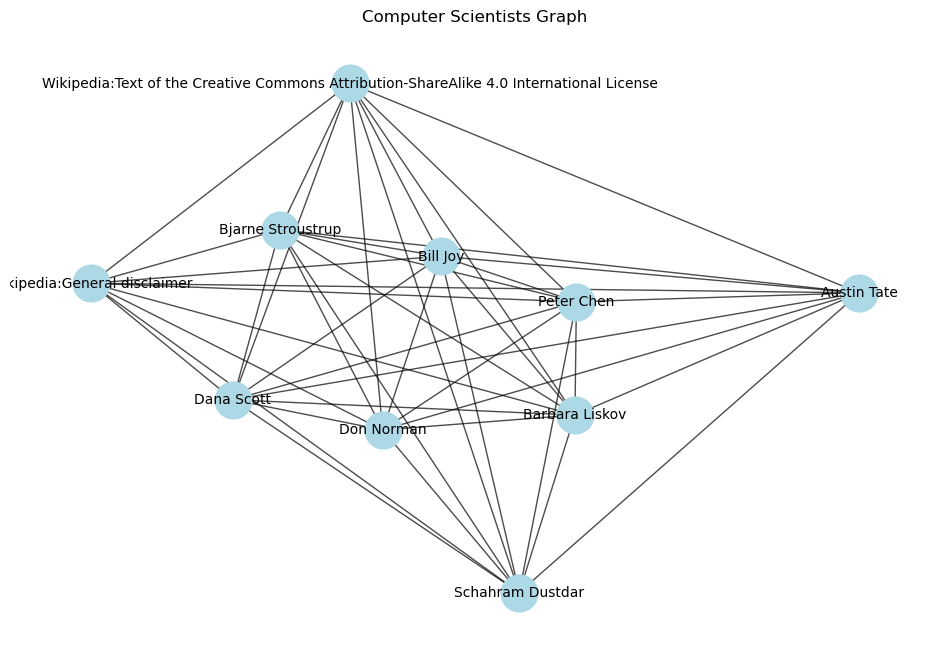

Ranking of Scientists by Name Length:
1. Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License - Name Length: 87
2. Wikipedia:General disclaimer - Name Length: 28
3. Bjarne Stroustrup - Name Length: 17
4. Schahram Dustdar - Name Length: 16
5. Barbara Liskov - Name Length: 14
6. Austin Tate - Name Length: 11
7. Peter Chen - Name Length: 10
8. Dana Scott - Name Length: 10
9. Don Norman - Name Length: 10
10. Bill Joy - Name Length: 8
Removing scientist: Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License
Scientist 'Wikipedia:Text of the Creative Commons Attribution-ShareAlike 4.0 International License' removed successfully.


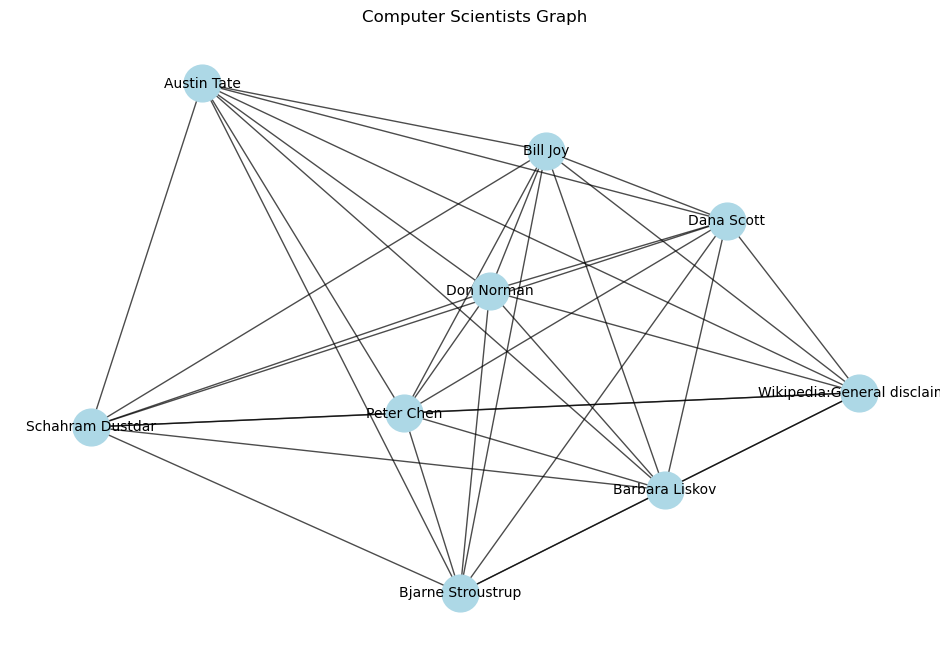

In [78]:
import time  # Ensure time is imported for delays

list_url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"
sg = ScientistGraph()

scientists = fetch_random_computer_scientists(list_url, count=10)
for scientist in scientists:
    sg.add_scientist(scientist.name)

sg.plot()
# Rank scientists by name length
sg.rank_scientists_by_name_length()
scientist_to_remove = scientists[0].name  # Remove the first scientist
print(f"Removing scientist: {scientist_to_remove}")
sg.remove_scientist(scientist_to_remove)
# Plot the initial graph
sg.plot()

# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

In [83]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple
import requests
from bs4 import BeautifulSoup
import random

class ScientistGraph:
    def __init__(self):
        """
        Initialize the ScientistGraph with an empty scientist list and a directed graph.
        """
        self.scientist_list: List[ComputerScientist] = []
        self.graph = nx.DiGraph()  # Directed graph to represent links between Wikipedia pages

    def add_scientist(self, scientist_name: str) -> bool:
        """
        Add a scientist to the graph, fetch their Wikipedia page, and establish directed edges.

        :param scientist_name: Name of the computer scientist.
        :return: True if added successfully, False otherwise.
        """
        if any(cs.name == scientist_name for cs in self.scientist_list):
            print(f"Scientist '{scientist_name}' is already in the graph.")
            return False

        scientist = fetch_scientist(scientist_name)
        if not scientist:
            print(f"Could not fetch information for scientist '{scientist_name}'.")
            return False

        # Add the scientist to the list and graph
        self.scientist_list.append(scientist)
        self.graph.add_node(scientist.name, wikipedia_link=scientist.wikipedia_link)

        # Establish edges to other scientists based on links in the Wikipedia page
        self.establish_edges(scientist)

        print(f"Scientist '{scientist.name}' added successfully.")
        return True

    def establish_edges(self, scientist: ComputerScientist):
        """
        Establish directed edges from the given scientist's page to other scientists in the graph.

        :param scientist: The scientist for whom edges will be established.
        """
        try:
            response = requests.get(scientist.wikipedia_link, timeout=10)
            response.raise_for_status()
        except requests.RequestException as e:
            print(f"Error fetching Wikipedia page for {scientist.name}: {e}")
            return

        soup = BeautifulSoup(response.text, 'html.parser')
        for link in soup.find_all('a', href=True):
            href = link['href']
            if href.startswith('/wiki/'):
                linked_scientist_name = link.text.strip()
                for existing_scientist in self.scientist_list:
                    if existing_scientist.name == linked_scientist_name:
                        self.graph.add_edge(scientist.name, existing_scientist.name)
                        print(f"Established directed edge from '{scientist.name}' to '{existing_scientist.name}'.")
                        break

    def remove_scientist(self, scientist_name: str) -> bool:
        """
        Remove a scientist from the graph, including their node and all associated edges.

        :param scientist_name: Name of the computer scientist.
        :return: True if removed successfully, False otherwise.
        """
        for cs in self.scientist_list:
            if cs.name == scientist_name:
                self.scientist_list.remove(cs)
                self.graph.remove_node(cs.name)
                print(f"Scientist '{scientist_name}' removed successfully.")
                return True

        print(f"Scientist '{scientist_name}' not found in the graph.")
        return False

    def plot(self):
        """
        Visualize the directed graph using matplotlib.
        """
        if not self.graph:
            print("The graph is empty. Nothing to plot.")
            return

        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)  # Seed for consistent layout
        nx.draw_networkx_nodes(self.graph, pos, node_size=700, node_color='lightblue')
        nx.draw_networkx_edges(self.graph, pos, edge_color='gray', arrows=True)
        nx.draw_networkx_labels(self.graph, pos, font_size=10)
        plt.title("Directed Graph of Computer Scientists")
        plt.axis('off')
        plt.show()

    def rank_scientists(self, method: str = "pagerank") -> List[Tuple[str, float]]:
        """
        Rank scientists based on the selected method (e.g., PageRank, number of neighbors).

        :param method: The ranking method to use ("pagerank" or "degree").
        :return: List of tuples containing scientist names and their scores, sorted by rank.
        """
        if method == "pagerank":
            scores = nx.pagerank(self.graph)
        elif method == "degree":
            scores = dict(self.graph.degree())
        else:
            print(f"Invalid ranking method: {method}. Supported methods: 'pagerank', 'degree'.")
            return []

        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        print(f"Ranking of Scientists using {method.capitalize()}:")
        for rank, (scientist, score) in enumerate(ranked, start=1):
            print(f"{rank}. {scientist} - Score: {score:.4f}")
        return ranked
    

Retrieving cached data for Alan Turing
Established directed edge from 'Alan Turing' to 'Alan Turing'.
Scientist 'Alan Turing' added successfully.
Retrieving cached data for John von Neumann
Established directed edge from 'John von Neumann' to 'Alan Turing'.
Established directed edge from 'John von Neumann' to 'John von Neumann'.
Scientist 'John von Neumann' added successfully.
Retrieving cached data for Grace Hopper
Established directed edge from 'Grace Hopper' to 'John von Neumann'.
Established directed edge from 'Grace Hopper' to 'Alan Turing'.
Scientist 'Grace Hopper' added successfully.
Retrieving cached data for Donald Knuth
Established directed edge from 'Donald Knuth' to 'Donald Knuth'.
Scientist 'Donald Knuth' added successfully.
Retrieving cached data for Edsger W. Dijkstra
Established directed edge from 'Edsger W. Dijkstra' to 'Grace Hopper'.
Established directed edge from 'Edsger W. Dijkstra' to 'Donald Knuth'.
Established directed edge from 'Edsger W. Dijkstra' to 'John von

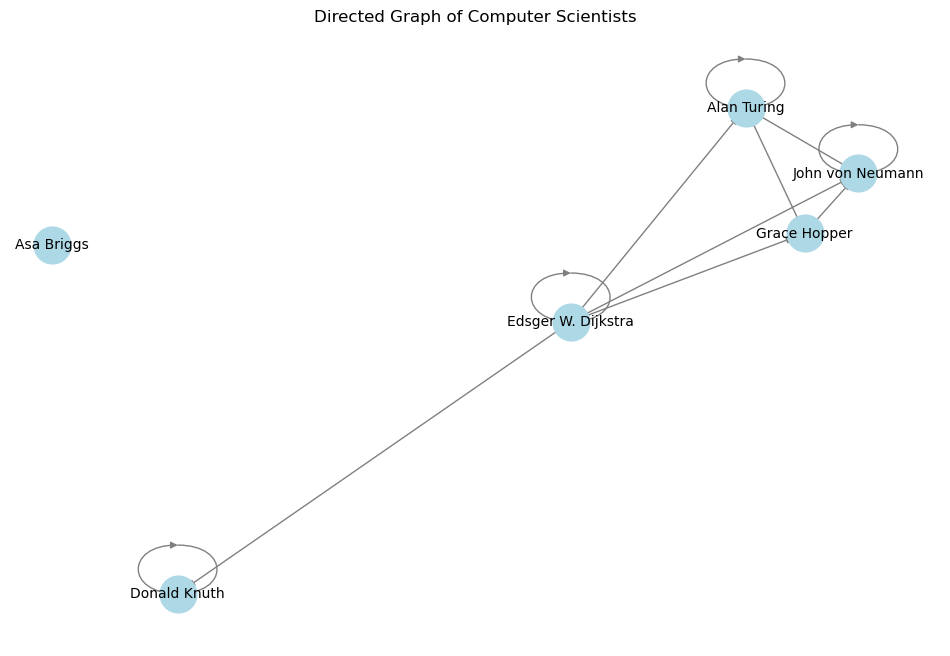

Ranking of Scientists using Pagerank:
1. Alan Turing - Score: 0.5798
2. Donald Knuth - Score: 0.2339
3. John von Neumann - Score: 0.0870
4. Grace Hopper - Score: 0.0351
5. Edsger W. Dijkstra - Score: 0.0351
6. Asa Briggs - Score: 0.0291
Ranking of Scientists using Degree:
1. Edsger W. Dijkstra - Score: 6.0000
2. Alan Turing - Score: 5.0000
3. John von Neumann - Score: 5.0000
4. Grace Hopper - Score: 3.0000
5. Donald Knuth - Score: 3.0000
6. Asa Briggs - Score: 0.0000
Removing scientist: Alan Turing
Scientist 'Alan Turing' removed successfully.


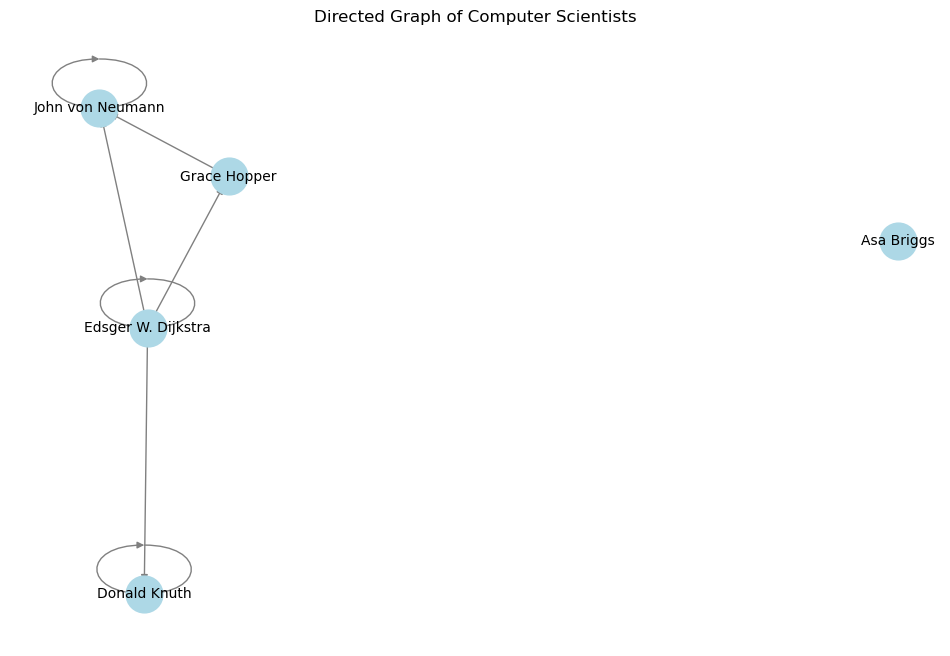

In [85]:
list_url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"

sg_new = ScientistGraph()

# Define a list of scientists likely to have links between their Wikipedia pages
predefined_scientists = [
    "Alan Turing",
    "John von Neumann",
    "Grace Hopper",
    "Donald Knuth",
    "Edsger W. Dijkstra",
    "Asa Briggs"
]

# Add the predefined scientists to the graph
for scientist_name in predefined_scientists:
    sg_new.add_scientist(scientist_name)



# Plot the graph
sg_new.plot()

 # Rank scientists by PageRank
sg_new.rank_scientists(method="pagerank")

# Rank scientists by the number of neighbors
sg_new.rank_scientists(method="degree")

# Remove a scientist
scientist_to_remove = predefined_scientists[0]  # Remove the first scientist
print(f"Removing scientist: {scientist_to_remove}")
sg_new.remove_scientist(scientist_to_remove)

# Re-plot the updated graph
sg_new.plot()